In [27]:
import numpy as np
import seaborn as sns
import scipy as sp
import functools
%pylab inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from scipy.stats import multivariate_normal
import scipy.stats as stats
import time
import scipy as scipy
import sys
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools

Populating the interactive namespace from numpy and matplotlib


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['multivariate_normal', 'var', 'pi']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Gaussian  Normal Distirbution

- $ cov
f(xp), f(xq)

= k(xp, xq) = exp
−
1
2
|xp − xq|
2

. $
- $f∗ ∼ N
0, K(X∗, X∗)

, $

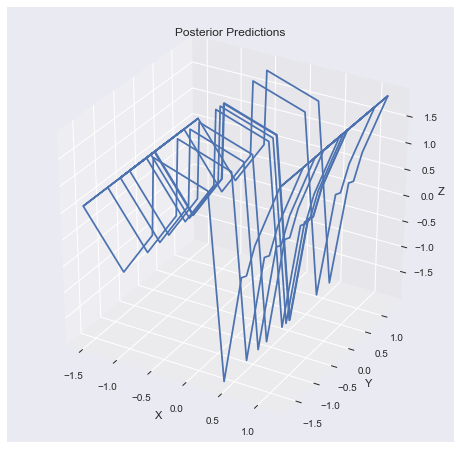

In [469]:


predicted_points = predictive_normal_noisy.rvs(10).T
predicted_points = np.array(sorted(predicted_points.T, key=lambda x: x[0])).T # sort the points

fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

#t = np.linspace(-3, 2, 31)
#s = np.linspace(-3, 2, 31)
x = predicted_points[0]
y = predicted_points[1]
z = predicted_points[2]

X, Y = np.meshgrid(x,y)
Z  = np.meshgrid(z,y)

ax.plot_wireframe(X,Y,Z[0],ccount=1, rcount=10)
#ax.plot_wireframe(X,Y,Z[1],ccount=1)
#ax.plot_surface(x,y,z, cmap=cm.jet, rstride=1, cstride=1)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_title('Posterior Predictions')

plt.show()

In [1708]:


x, y = np.mgrid[-5.0:5.0:50j, -5.0:5.0:50j]

# Need an (N, 2) array of (x, y) pairs.
xy = np.column_stack([x.flat, y.flat])
print(xy)
mu = np.array([0.0, 0.0])

sigma = np.array([.5, .5])
covariance = np.diag(sigma**2)

z =predictive_normal_noisy .pdf(xy)

# Reshape back to a (30, 30) grid.
z = z.reshape(x.shape)





fig = plt.figure(figsize=(10,8))

ax = fig.add_subplot(111, projection='3d')



ax.plot_surface(x,y,z)
#ax.plot_wireframe(x,y,z)
plt.title('PDF of multivariate gaussian process')
plt.show()

[[-5.         -5.        ]
 [-5.         -4.79591837]
 [-5.         -4.59183673]
 ..., 
 [ 5.          4.59183673]
 [ 5.          4.79591837]
 [ 5.          5.        ]]


ValueError: operands could not be broadcast together with shapes (2500,2) (20,) 

# New Attempt from Readings. Bayesian Gaussian Process Regression
- Gaussian Process for Regression: A Quick Introduction
    - M. Ebden
- http://haikufactory.com/files/bayopt.pdf

###  Assmptions
- Prior is a Gaussian Process with mean = 0
- Pick the domain to optimize over
- Starting wit ha 1D domain

### Kernels

In [85]:
def squarred_kernel(a, b, param=2.0, train=False, train_noise = 5e-3, vertical_scale=50):
    """Calculated the squarred exponential kernel. 
    Adds a noise term for the covariance of the training data
    Adjusting the param changes the difference where points will have a positive covariance
    Returns a covaraince Matrix.
    Vertical scale controls the vertical scale of the function"""
    if train == False:
        a = np.array(a)
        b = np.array(b)
        
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T)
        return vertical_scale*np.exp(-.5 * (1/param) * sqdist)

    else:
        noisy_observations = train_noise*np.eye(len(a))
        a = np.array(a)
        b = np.array(b)
        
        sqdist = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2*np.dot(a, b.T) 
        return vertical_scale*np.exp(-.5 * (1/param) * sqdist) + noisy_observations 

In [18]:
def matern_kernel(a,b,C_smoothness=3/2,train=False, train_noise = 5e-2):
    """The class of Matern kernels is a generalization of the RBF and the
    absolute exponential kernel parameterized by an additional parameter
    nu. The smaller nu, the less smooth the approximated function is.
    For nu=inf, the kernel becomes equivalent to the RBF kernel and for nu=0.5
    to the absolute exponential kernel. Important intermediate values are
    nu=1.5 (once differentiable functions) and nu=2.5 (twice differentiable
    functions).
    
    c_smoother = inf = RBF
    
    The train keyword is used to add noisy observations to the matrix"""
    if C_smoothness not in [1/2,3/2]:
        return "You choose an incorrect hyparameter, please choose either 1/2 or 3/2"
    matrix_norm = np.array([np.linalg.norm(a[i] - b,axis=(1)) for i in range(len(a))])
    if C_smoothness == 1/2:
        if train == True:
            max(np.var(a),np.var(b)) * np.exp(-matrix_norm) + np.eye(len(matrix_norm))*train_noise
        else:
            return max(np.var(a),np.var(b)) * np.exp(-matrix_norm)
    elif C_smoothness == 3/2:
        if train == True:
            return max(np.var(a),np.var(b))* (1 +np.sqrt(3)*matrix_norm)*np.exp(-np.sqrt(3)*matrix_norm) + np.eye(len(matrix_norm))*train_noise
        else:
            return max(np.var(a),np.var(b))* (1 +np.sqrt(3)*matrix_norm)*np.exp(-np.sqrt(3)*matrix_norm)
 
   

In [19]:
from math import pi

In [128]:
test_x = np.array(np.linspace(-10,10)).reshape(-1,1)
train_x = np.array(np.linspace(-10,10,1)).reshape(-1,1)

train_y_func = lambda x: cos(1000*x)+(abs(x*100_000))/(x**4+1000)
train_y_func_two_d = lambda a,b : (a*b)/(a-1/(b+1)) - b
#train_y_numbers = np.array([train_y_func(_) for _ in train_x)]).reshape(-1,1)
#train_y_numbers = np.array([train_y_func(_,i) for _,i in zip(train_x,train_x)]).reshape(-1,1)
y_var = 100
#max_covariance = np.sqrt(y_var) ## not sure a good number to choose for the noise of measuring your observations
max_covariance = 5


In [129]:
# Two dimensional training points
test_two_d_x = np.squeeze(np.array(list(itertools.product(*[test_x ,test_x ]))))
train_two_d_x = np.array(list(itertools.product(*[np.linspace(-10,10,2),np.linspace(-10,10,2)])))
train_y_numbers_two_d = np.array([train_y_func(x,y) for x,y in train_two_d_x]).reshape(-1,1)

TypeError: <lambda>() takes 1 positional argument but 2 were given

In [22]:
from numpy import linalg as la
#https://stackoverflow.com/questions/43238173/python-convert-matrix-to-positive-semi-definite/43244194#43244194
def nearestPD(A):
    """Find the nearest positive-definite matrix to input

    A Python/Numpy port of John D'Errico's `nearestSPD` MATLAB code [1], which
    credits [2].

    [1] https://www.mathworks.com/matlabcentral/fileexchange/42885-nearestspd

    [2] N.J. Higham, "Computing a nearest symmetric positive semidefinite
    matrix" (1988): https://doi.org/10.1016/0024-3795(88)90223-6
    """

    B = (A + A.T) / 2
    _, s, V = la.svd(B)

    H = np.dot(V.T, np.dot(np.diag(s), V))

    A2 = (B + H) / 2

    A3 = (A2 + A2.T) / 2

    if isPD(A3):
        return A3

    spacing = np.spacing(la.norm(A))
    # The above is different from [1]. It appears that MATLAB's `chol` Cholesky
    # decomposition will accept matrixes with exactly 0-eigenvalue, whereas
    # Numpy's will not. So where [1] uses `eps(mineig)` (where `eps` is Matlab
    # for `np.spacing`), we use the above definition. CAVEAT: our `spacing`
    # will be much larger than [1]'s `eps(mineig)`, since `mineig` is usually on
    # the order of 1e-16, and `eps(1e-16)` is on the order of 1e-34, whereas
    # `spacing` will, for Gaussian random matrixes of small dimension, be on
    # othe order of 1e-16. In practice, both ways converge, as the unit test
    # below suggests.
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1

    return A3

def isPD(B):
    """Returns true when input is positive-definite, via Cholesky"""
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False


In [241]:
def test_gaussian_process(test_x, train_x, train_y_numbers, y_var, kernel, return_cov = False,
                          return_sample = False, covariance_noise = 5e-5, n_posteriors = 5):
    """Test one new point in the Gaussian process or an array of points
    Returns the mean, var from normal distribution from the sampled point.
    Return cov = True will return the full covariance matrix.
    
    If return_sample= True 
    returns samples ( a vector) from the informed posterior and the uninformed prior distribution
    
    Covariance diagonal noise is used to help enforce positive definite matrices
    
    N_posteriors indicates the number of posterior functions to create when sampling"""
    
    
    # define the covariance matrices
    covariance_train_train = kernel(train_x,train_x,train=True)
    covariance_test_train  = kernel(test_x,train_x)
    covariance_test_test  = kernel(test_x,test_x)
    

    # Use cholskey decomposition to increase speed for calculating mean
    try :# First try, 
        L_test_test = np.linalg.cholesky(covariance_test_test + covariance_noise*np.eye(len(covariance_test_test)))
        L_train_train = np.linalg.cholesky(covariance_train_train + covariance_noise*np.eye(len(covariance_train_train)))
        Lk = np.linalg.solve(L_train_train, covariance_test_train.T)
        mus = np.dot(Lk.T, np.linalg.solve(L_train_train, train_y_numbers)).reshape((len(test_x),))
        # Compute the standard deviation so we can plot it
        s2 = np.diag(covariance_test_test) - np.sum(Lk**2, axis=0)
        stdv = np.sqrt(abs(s2))
        

    # Full matrix calculation of mean and covariance, much slower than cholesky decomposition
    except Exception as e:
        print(e)#LinAlgError: # In case the covariance matrix is not positive definite 
        # Find the near positive definite matrix to decompose
        decompose_train_train = nearestPD(covariance_train_train + covariance_noise*np.eye(len(train_x)))
        decompose_test_test = nearestPD(covariance_test_test + covariance_noise*np.eye(len(test_x)))
        
        # cholskey decomposition within the try except block
        L_train_train = np.linalg.cholesky(decompose_train_train  )
        L_test_test = np.linalg.cholesky(decompose_test_test  )
        Lk = np.linalg.solve(L_train_train, covariance_test_train.T)
        mus = np.dot(Lk.T, np.linalg.solve(L_train_train, train_y_numbers)).reshape((len(test_x),))
        # Compute the standard deviation so we can plot it
        s2 = np.diag(covariance_test_test) - np.sum(Lk**2, axis=0)
        stdv = np.sqrt(abs(s2))
        
        
#         ##### FULL INVERSION ####
#         mus = covariance_test_train  @ np.linalg.pinv(covariance_train_train) @ train_y_numbers
#         s2 = covariance_test_test - covariance_test_train @ np.linalg.pinv(covariance_train_train ) \
#                      @ covariance_test_train.T
        

    def sample_from_posterior(n_priors=3, n_post=5):
        """Draw samples from the prior distribution of the GP.
        len(test_x) is the number of samplese to draw.
        Resource: http://katbailey.github.io/post/gaussian-processes-for-dummies/.
        
        N-Posteriors / N-Priors tells the number of functions to samples from the dsitribution"""

        # Draw samples from the posterior at our test points.
        covariance_test_test  = kernel(test_x,test_x)
        try: # try inside sample from posterior function
            L = np.linalg.cholesky(covariance_test_test +  covariance_noise*np.eye(len(test_x))- np.dot(Lk.T, Lk))
        except Exception as e:
            # Find the neareset Positive Definite Matrix
            near_decompose = nearestPD(covariance_test_test +  covariance_noise*np.eye(len(test_x))- np.dot(Lk.T, Lk))
            L = np.linalg.cholesky(near_decompose.astype(float) ) # within posterior
        # sample from the posterior
        f_post = mus.reshape(-1,1) + np.dot(L, np.random.normal(size=(len(test_x),n_posteriors)))

        # Sample X sets of standard normals for our test points,
        # multiply them by the square root of the covariance matrix
        f_prior_uninformed = np.dot(L_test_test, np.random.normal(size=(len(test_x),n_priors)))
        # For the posterior, the columns are the vector for that function
        return (f_prior_uninformed, f_post)


    if return_cov == True:
        return y_pred_mean.ravel(), var_y_pred_diag.ravel(), var_y_pred
        
    if return_sample == True:
        f_prior, f_post = sample_from_posterior(n_post = n_posteriors)
        return mus.ravel(), s2.ravel(), f_prior, f_post
    else:
        return mus.ravel(), s2.ravel()
    
   

In [245]:
# Two dimensional works!
m,v,prior, post = test_gaussian_process(test_two_d_x, train_two_d_x, train_y_numbers_two_d, y_var,squarred_kernel, return_sample = True )

In [121]:
# m,var, prior, post = test_gaussian_process(np.array([[-10]]), train_x, train_y_numbers, 
#                                                    y_var,squarred_kernel, return_sample = True)

### Show the posterior learning the true underlying function with a squarred (RBF) kernel

In [136]:

def sample_and_plot_posterior(test_x, train_y_func, test_gaussian_process,kernel, range_to_sample=np.linspace(-10,10,25)):
    """Plot potential posterior functions after sampling from the true function.
    Notice how the varaince decreases around the sampled points"""
    # one d
    train_x = np.array(np.linspace(-10,10,1)).reshape(-1,1)
    train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)
    
#     # TWO D
#     train_x = np.array([[1,2],[2,1]])
#     train_y_numbers = np.array([train_y_func(x,y) for x,y in train_x]).reshape(-1,1)

    # shuffle the range
    shuffle(range_to_sample)
    # go through the points in the range
    for sampled_point in range_to_sample:
        # ONE D
        print(f"Point Sampled x = {train_x.ravel()[-1]}")
        
        
        m,var, prior, post = test_gaussian_process(test_x, train_x, train_y_numbers, 
                                                   y_var,kernel, return_sample = True)

        plt.figure(figsize=(14,10))

        plt.gca().fill_between(test_x.flat, m-2*np.sqrt(var), m+2*np.sqrt(var), color="#dddddd",label='95% confidence')
        plt.scatter(train_x.ravel(), train_y_numbers,marker='*',label='Samples', linewidth=5, color='red')

        plt.plot(np.linspace(-10,10,400),[train_y_func(i) for i in np.linspace(-10,10,400)], label='real function',
                linestyle="--")
        plt.plot(test_x,post,color='black',label='Draws from the posterior')
        #plt.scatter(train_x,train_y_numbers)
        #plt.scatter(test_x,m,label='MU',color='red', linewidth=10, marker='*');
        plt.legend()
        plt.title('Posteriors, and Actual Function')
        plt.show();

        # Update training data with the sampled point
        train_x = train_x.ravel()
        train_x = np.append(train_x,sampled_point)
        train_x = train_x.reshape(-1,1)
        train_y_numbers = np.array([train_y_func(_) for _ in train_x]).reshape(-1,1)

        # sleep for three seconds
        time.sleep(1)

Point Sampled x = -10.0


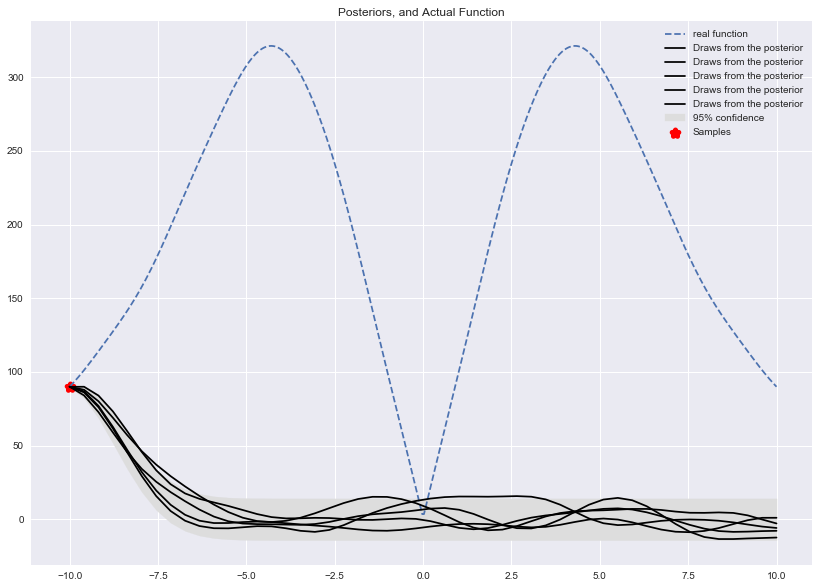

Point Sampled x = 3.333333333333334


KeyboardInterrupt: 

In [137]:
# one dimensional
sample_and_plot_posterior(test_x, train_y_func, test_gaussian_process, squarred_kernel)

### Best estimate for Y* is given by the mean of the distribution


### Implement Expected Improvement


In [138]:
def expected_improvement(mean_x, sigma_squarred_x, y_val_for_best_hyperparameters, normal_dist=None, point_est = False):
    """Finds the expected improvement of a point give the current best point.
    If point_est = False, then computes the expected value on a vector from the posterior distribution.
    """
    from scipy.stats import norm
    
    with np.errstate(divide='ignore'): # in case sigma equals zero
        # Expected val for one point
        if point_est ==True:
            sigma_x = np.sqrt(sigma_squarred_x) # get the standard deviation from the variance

            Z = (mean_x - y_val_for_best_hyperparameters) / sigma_x

            if round(sigma_x,8) == 0:
                return 0
            else:
                return (mean_x - y_val_for_best_hyperparameters)*normal_dist.cdf(Z) + sigma_x*normal_dist.pdf(Z)

        else:
            # Sample from the posterior functions
            for _ in range(len(mean_x)):
                list_of_improvements = []
                m_s = []
                for m,z,s in zip(mean_x, ((mean_x -y_val_for_best_hyperparameters)\
                                     / np.std(sigma_squarred_x)),np.sqrt(sigma_squarred_x) ):
                    
                    list_of_improvements.append(((m-y_val_for_best_hyperparameters)*norm(m,s).cdf(z)\
                                                 +s*norm(m,s).pdf(z)))
                    m_s.append(m)

                return list_of_improvements

In [139]:
def thompson_sampling():
    """Thompson sampling to find the next point to pick"""

In [140]:
m,var, prior, post =  test_gaussian_process(np.array([[-400]]), train_x, train_y_numbers, 
                                                   y_var,squarred_kernel, return_sample = True)

In [1075]:
m

array([ 0.])

In [247]:
def sample_from_function( y_function, 
                        train_x, train_y_numbers, kernel, y_var, testing_domain = range(-100,100,10), n = 20,
                        verbose=True):
    """Sample N times from the unknown function and for each time find the 
    point that will have the highest expected improvement (find the maxima of the function).
    Verbose signifies if the function should print out the points where it is sampling
    
    Returns a generator of x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                list_of_expected_improvements, testing_domain, mus
          for improvements. Mus and Vars are the mean and var for each sampled point in the gaussian process. 
    
    Starts off the search for expected improvement with a coarse search and then hones in on 
    the domain the the highest expected improvement."""

    
    if train_x.shape[1]>1: # Two dimensional 
        # Random starting point
        start_point = np.array([testing_domain[np.random.choice(len(testing_domain)),:]])
        #start at random point in the domain
        best_x = start_point
        best_y = y_function(start_point[0][0],start_point[0][1]) # initial best y value based on start point
        start_y = y_function(start_point[0][0],start_point[0][1])
        # for plotting the points sampled
        x_sampled_points = []
        y_sampled_points = []
        sampled_variance = [] 
        
    else: # One dimensional case
        start_point = np.random.choice(testing_domain)#start at random point in the domain
        best_x = start_point
        best_y = y_function(start_point) # initial best y value based on start point
        start_y = y_function(start_point) 
        # for plotting the points sampled
        x_sampled_points = []
        y_sampled_points = []
        sampled_variance =[] 
    

    for i in range(n):
        if i == 0:
            if train_x.shape[1]==1: ## one dimensional case
                testing_domain = np.array([testing_domain]).reshape(-1,1)
            
            
            
            # find the next x-point to sample
            mus, vars_,_,post = test_gaussian_process(testing_domain, train_x, train_y_numbers,
                                               y_var, kernel, return_sample = True, n_posteriors=30)
            
           
            sigmas_post = np.var(post,axis=1)
            mus_post = np.mean(post,axis=1)
            # get the expected values from the posterior distribution
            list_of_expected_improvements = expected_improvement(mus_post, sigmas_post ,best_y)

            max_improv_x_idx = np.argmax(list_of_expected_improvements)
            max_improv_x = testing_domain[max_improv_x_idx]
            
            if train_x.shape[1]==1:
                max_improv_y = y_function(max_improv_x)
            else: # Two D
                max_improv_y = y_function(max_improv_x[0],max_improv_x[1])
                
            if max_improv_y > best_y: ## use to find out where to search next
                best_y = max_improv_y 
                best_x = max_improv_x
            else:
                best_x = start_point
            

            sampled_variance.append(sigmas_post[max_improv_x_idx])

            # append the point to sample
            x_sampled_points.append(max_improv_x)
            y_sampled_points.append(max_improv_y)
            
            # append our new the newly sampled point to the training data
            train_x = np.vstack((train_x, max_improv_x))
            train_y_numbers = np.vstack((train_y_numbers, max_improv_y))
            yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                list_of_expected_improvements, testing_domain, mus
            

        else:
            # reformat testing domain to include more possible points
            if train_x.shape[1]==1:
                testing_domain = np.linspace(testing_domain[0],testing_domain[-1],
                                        num=1_000).reshape(-1,1)
            
            
            mus, vars_,_,post = test_gaussian_process(testing_domain, train_x, train_y_numbers,
                                               y_var, kernel, return_sample = True, n_posteriors=30)

            sigmas_post = np.var(post,axis=1)
            mus_post = np.mean(post,axis=1)
            
            # get the expected values from the posterior distribution
            list_of_expected_improvements = expected_improvement(mus_post, sigmas_post, best_y)
            
            
            # find the best x value
            max_improv_x_idx = np.argmax(list_of_expected_improvements)
            print(max_improv_x_idx,'max_improv_x_idx')
            max_improv_x = testing_domain[max_improv_x_idx]
            
            if train_x.shape[1]==1:
                max_improv_y = y_function(max_improv_x)
            else: # Two D
                max_improv_y = y_function(max_improv_x[0],max_improv_x[1])
  
            if max_improv_y > best_y: ## use to find out where to search next
                best_y = max_improv_y 
                best_x = max_improv_x
            else:
                pass
            if verbose:
                print(f"Bayesian Optimization just sampled point = {max_improv_x}")
                print(f"Best x (Bayesian OPtimization) = {best_x}, Best y = {best_y}")
                sampled_variance.append(sigmas_post[max_improv_x_idx])

                # append the point to sample
                x_sampled_points.append(max_improv_x)
                y_sampled_points.append(max_improv_y)

                # append our new the newly sampled point to the training data
                train_x = np.vstack((train_x, max_improv_x))
                train_y_numbers = np.vstack((train_y_numbers, max_improv_y))

                yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                    list_of_expected_improvements, testing_domain, mus
                    
            else:

                sampled_variance.append(sigmas_post[max_improv_x_idx])

                # append the point to sample
                x_sampled_points.append(max_improv_x)
                y_sampled_points.append(max_improv_y)

                # append our new the newly sampled point to the training data
                train_x = np.vstack((train_x, max_improv_x))
                train_y_numbers = np.vstack((train_y_numbers, max_improv_y))

                yield x_sampled_points, y_sampled_points, vars_, best_x, best_y, \
                    list_of_expected_improvements, testing_domain, mus
         


    

# Test Bayesian optimization, initially using squarred kernel

In [250]:
# Create the generator, TWO DIMENSIONAL
samples = 10
gen_two_d = sample_from_function(train_y_func_two_d,train_two_d_x,
                                 train_y_numbers_two_d, squarred_kernel, y_var, n=samples,
                                 testing_domain=test_two_d_x )

In [249]:
x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen_two_d)
    

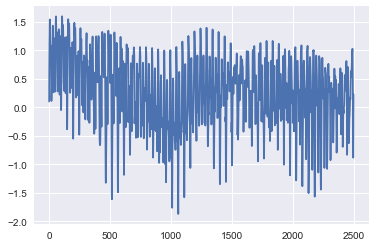

27 max_improv_x_idx
Bayesian Optimization just sampled point = [-10.           1.02040816]
Best x (Bayesian OPtimization) = [-10.           1.02040816], Best y = -0.04812319538017329


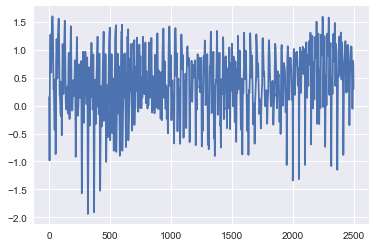

1528 max_improv_x_idx
Bayesian Optimization just sampled point = [ 2.24489796  1.42857143]
Best x (Bayesian OPtimization) = [ 2.24489796  1.42857143], Best y = 0.3208906352324816


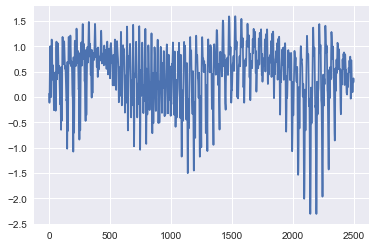

1465 max_improv_x_idx
Bayesian Optimization just sampled point = [ 1.83673469 -3.87755102]
Best x (Bayesian OPtimization) = [ 1.83673469 -3.87755102], Best y = 0.6169239944337686


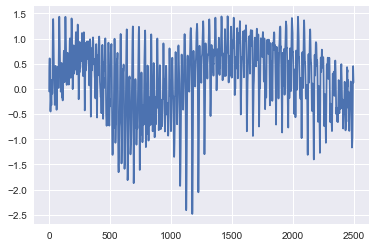

1788 max_improv_x_idx
Bayesian Optimization just sampled point = [ 4.28571429  5.51020408]
Best x (Bayesian OPtimization) = [ 1.83673469 -3.87755102], Best y = 0.6169239944337686


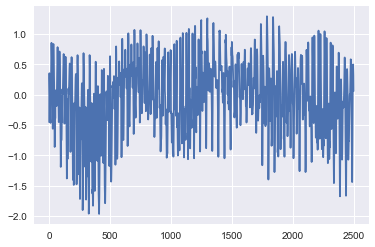

1874 max_improv_x_idx
Bayesian Optimization just sampled point = [ 5.10204082 -0.20408163]
Best x (Bayesian OPtimization) = [ 1.83673469 -3.87755102], Best y = 0.6169239944337686


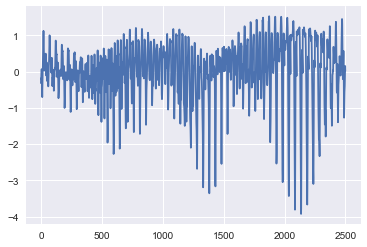

In [ ]:
for i in range(samples): # TWO D
    x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen_two_d)
    plt.plot(improvements)
    plt.show()

In [216]:
# Create the generator, ONE DIMENSIONAL
samples = 10
gen = sample_from_function(train_y_func,train_x, train_y_numbers,squarred_kernel, y_var, n=samples )

In [218]:
# Used for Expected Improvement  - One Dimensional

for i in range(samples):
    # sample from generator
    x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen)
    
    
        # Expectd Improvement
    plt.figure(figsize=(12,10))
    plt.title('Expected Improvement')
    plt.plot(domain,improvements,label='Expected improvements',color='green')
    
    
    
     # 95% confidence bars
    plt.figure(figsize=(12,10))
    plt.title("Function vs Sampled Points")
    plt.gca().fill_between( domain.flat, mus-2*np.sqrt(sampled_var),
                           mus+2*np.sqrt(sampled_var), color="#dddddd",label='95% confidence')
    
    
    
    train_y_x_axis = np.array(np.linspace(-100,100,1000))
    train_y_numbers_ = [train_y_func(i) for i  in train_y_x_axis]
    
    plt.plot(train_y_x_axis,train_y_numbers_, label=' actual function',linestyle="--")
    
    #print(f"Point on x-axis just sampled ={x_sampled_points[-1]}")
    plt.scatter(x_sampled_points,y_sampled_points, color='red',marker='X',label='sampled points',linewidths=5)
    plt.scatter(best_x,best_y, marker = "*",label='Best BO point',linewidths=6, color = 'green')

    
    mus = np.array(mus)
    domain = np.array(domain)

    plt.legend()
#     plt.ylim(-100,100)

    
    plt.show();


    
    # pause so we can see the graph
    #time.sleep(3);


StopIteration: 

# Objective Function

In [1172]:
# MSE
def mean_squarred_error(actual, predicted, negative = True):
    """MSE of actual and predicted value.
    Negative turn the MSE negative to allow for maximization instead of minimization"""
    if negative == True:
        return -np.linalg.norm(actual - predicted)/np.sqrt(len(actual))
    else:
        return np.linalg.norm(actual - predicted)/np.sqrt(len(actual))

In [1104]:
y = np.array([1,2]).reshape(-1,1)

In [1105]:
y_hat= np.array([2,1]).reshape(-1,1)

In [1106]:
mean_squarred_error(y,y_hat)

1.0

# Toy data set to optimize
- Wine ratings
- Use elastic net (find best hyperparamter fir L1 ratio)

In [1107]:
! curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10782  100 10782    0     0  63083      0 --:--:-- --:--:-- --:--:-- 81681


In [1110]:
cols = ['Alcohol','Malic acid','Ash','Alcalinity of ash  ','Magnesium','Total phenols','Flavanoids',
        'Nonflavanoid phenols','Proanthocyanins','Color intensity','Hue','OD280','Proline    ']

In [1112]:
wine_df = pd.read_csv("wine.data",names=cols)

In [1115]:
wine_df .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 1 to 3
Data columns (total 13 columns):
Alcohol                 178 non-null float64
Malic acid              178 non-null float64
Ash                     178 non-null float64
Alcalinity of ash       178 non-null float64
Magnesium               178 non-null int64
Total phenols           178 non-null float64
Flavanoids              178 non-null float64
Nonflavanoid phenols    178 non-null float64
Proanthocyanins         178 non-null float64
Color intensity         178 non-null float64
Hue                     178 non-null float64
OD280                   178 non-null float64
Proline                 178 non-null int64
dtypes: float64(11), int64(2)
memory usage: 19.5 KB


In [1116]:
wine_df.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [1117]:
wine_df.describe()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


### Train test split to predict alcohol content

In [1167]:
X_train, X_test, y_train, y_test = train_test_split(wine_df.iloc[:,1:],wine_df.iloc[:,0], test_size=.2)

## Elastic Net Model
- Find the best L1 ratio
- Predicting the alcohol content
- Use squarred kernel

In [1564]:
def hyperparam_choice_function(hyperparameter_value, X_train_in=X_train, 
                               X_test_in = X_test, y_train_in = y_train, y_test_in = y_test,
                               model = ElasticNet):
    """Returns the negative MSE of the input hyperparameter for the given  hyperparameter.
    Used with GLMnet search over .
    Relies on a global name scope to bring in the data"""
    m = model(l1_ratio = hyperparameter_value)
    m.fit(X_train_in, y_train_in)
    pred = m.predict(X_test_in)
    n_mse = mean_squarred_error(y_test_in, pred)
    return n_mse
    

In [1429]:
ElasticNet()

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [1629]:
hyper_param_range = np.linspace(0,1,500)
train_x_hyp = np.array(np.random.choice(hyper_param_range,1)).reshape(-1,1)
train_y_hyp = np.array([hyperparam_choice_function(i) for i in train_x_hyp]).reshape(-1,1)
y_var_hyp = 5

In [1630]:

samples = 10
gen_hyp = sample_from_function(hyperparam_choice_function, train_x_hyp, train_y_hyp,
                               squarred_kernel, y_var_hyp, testing_domain = range(0,2), n=samples )

## Show Expected Improvement + Bayesian OPtimization points for L1 hyparameter selection

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


STEP NUMBER = 0
Point on x-axis just sampled =[0]


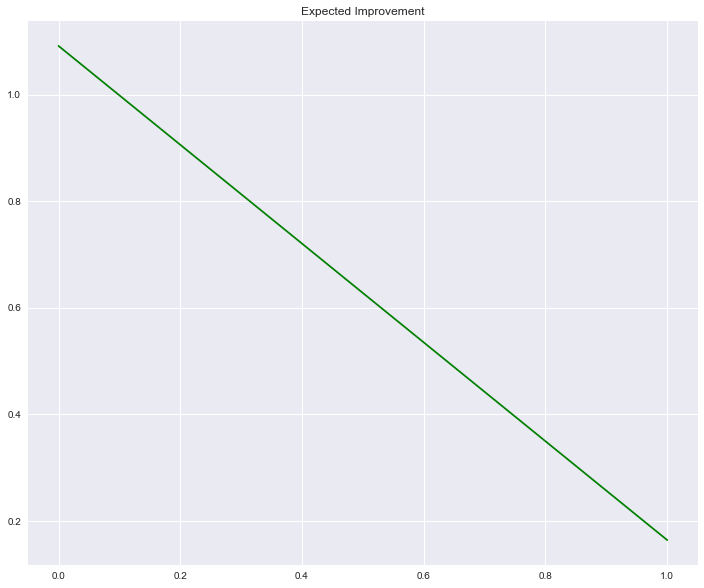

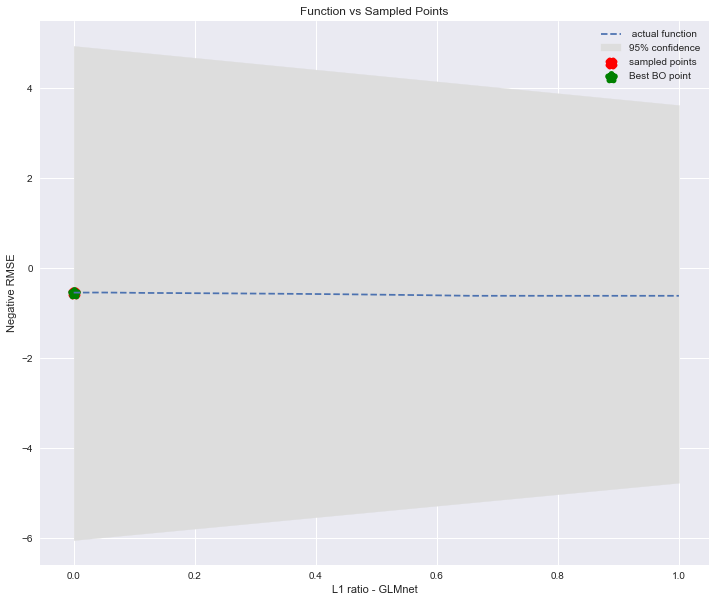

STEP NUMBER = 1
Bayesian Optimization just sampled point = [ 0.81781782]
Best x (Bayesian OPtimization) = 0, Best y = -0.5451045527465782
Point on x-axis just sampled =[ 0.81781782]


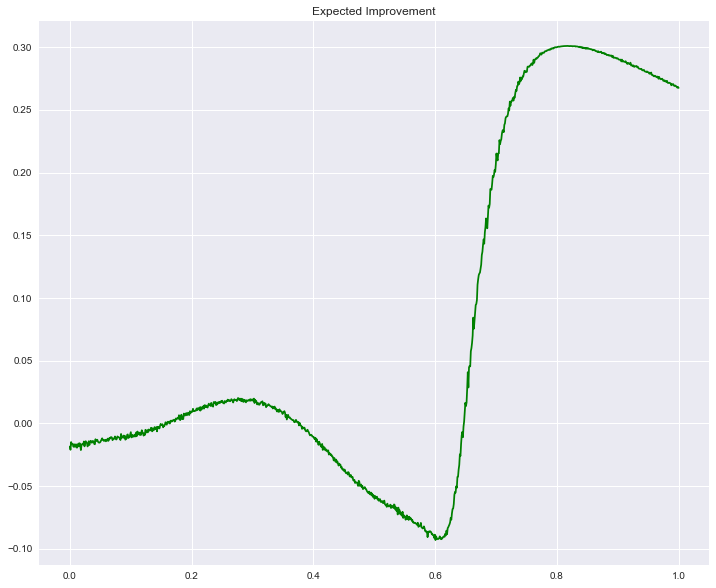

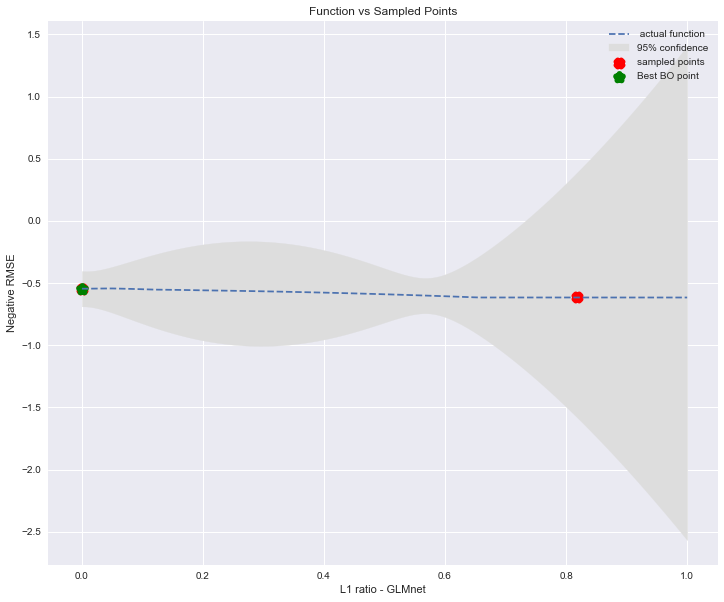

STEP NUMBER = 2
Bayesian Optimization just sampled point = [ 0.15415415]
Best x (Bayesian OPtimization) = 0, Best y = -0.5451045527465782
Point on x-axis just sampled =[ 0.15415415]


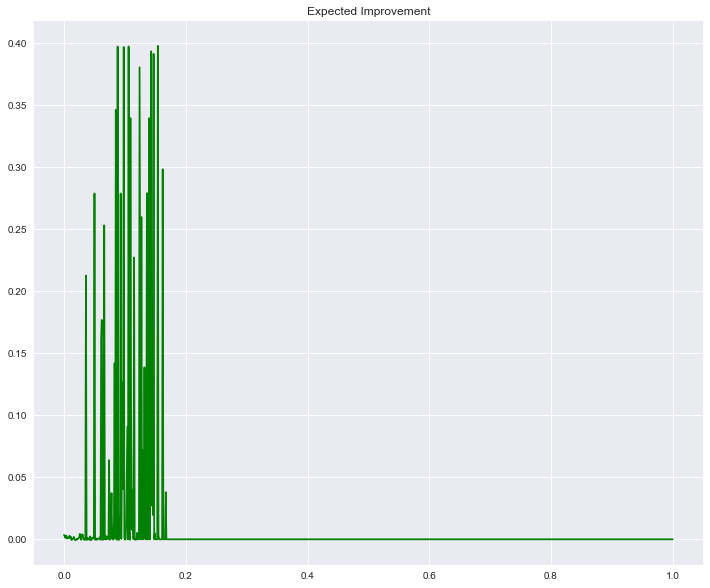

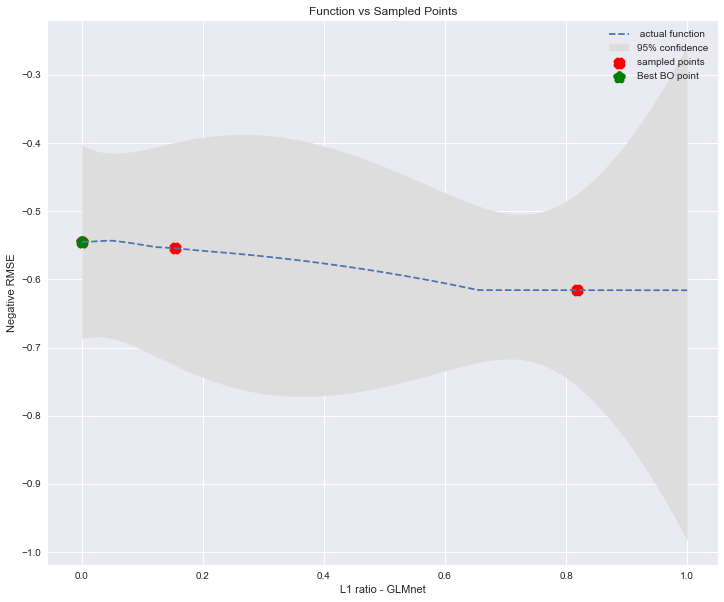

STEP NUMBER = 3
Bayesian Optimization just sampled point = [ 0.1001001]
Best x (Bayesian OPtimization) = 0, Best y = -0.5451045527465782
Point on x-axis just sampled =[ 0.1001001]


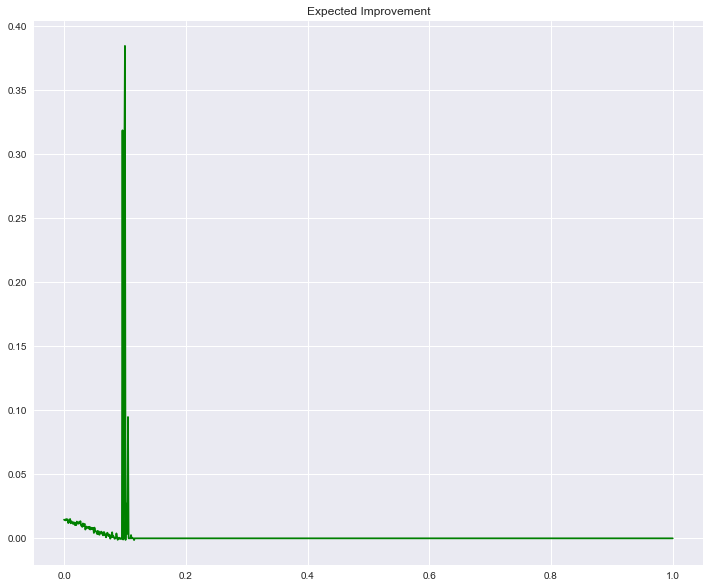

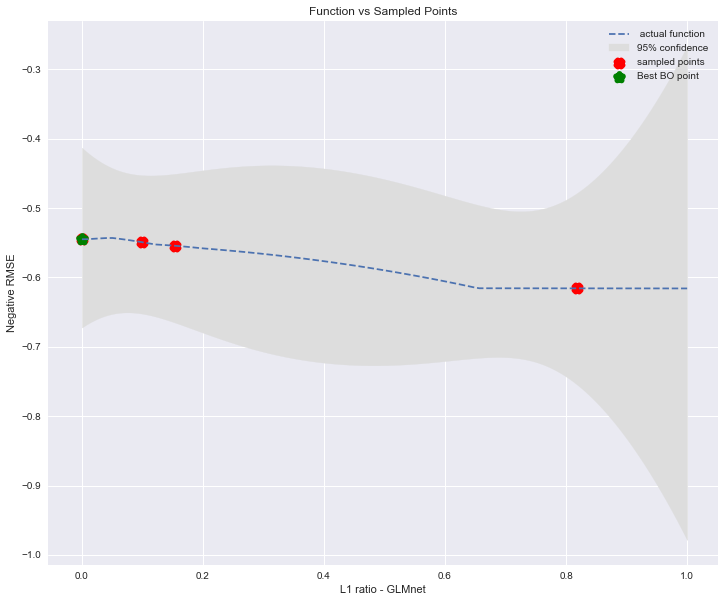

STEP NUMBER = 4
Bayesian Optimization just sampled point = [ 0.02402402]
Best x (Bayesian OPtimization) = [ 0.02402402], Best y = -0.5441552913817677
Point on x-axis just sampled =[ 0.02402402]


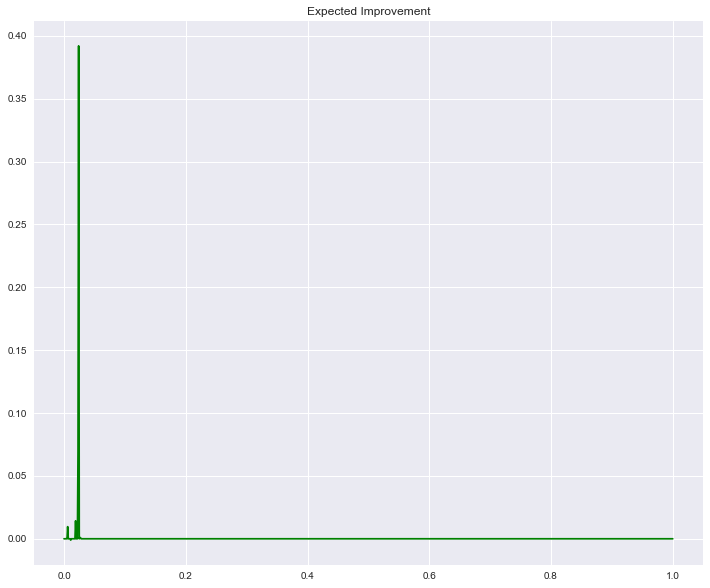

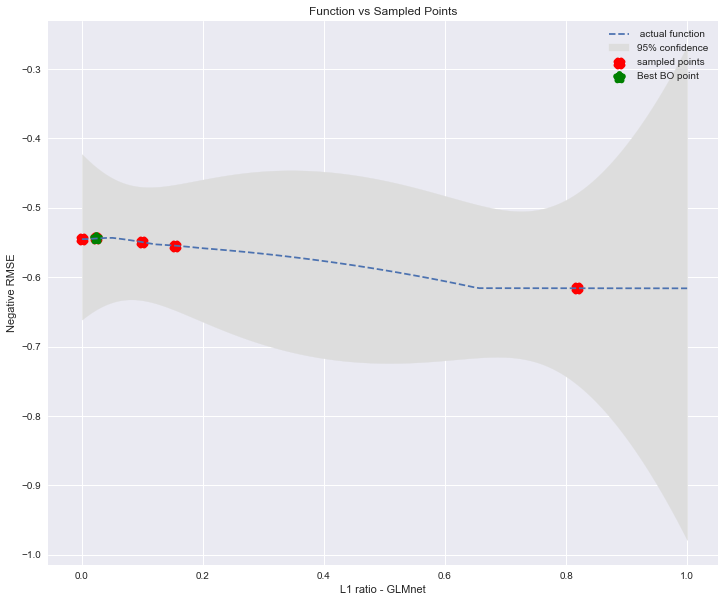

STEP NUMBER = 5
Bayesian Optimization just sampled point = [ 0.04804805]
Best x (Bayesian OPtimization) = [ 0.04804805], Best y = -0.5431180847562334
Point on x-axis just sampled =[ 0.04804805]


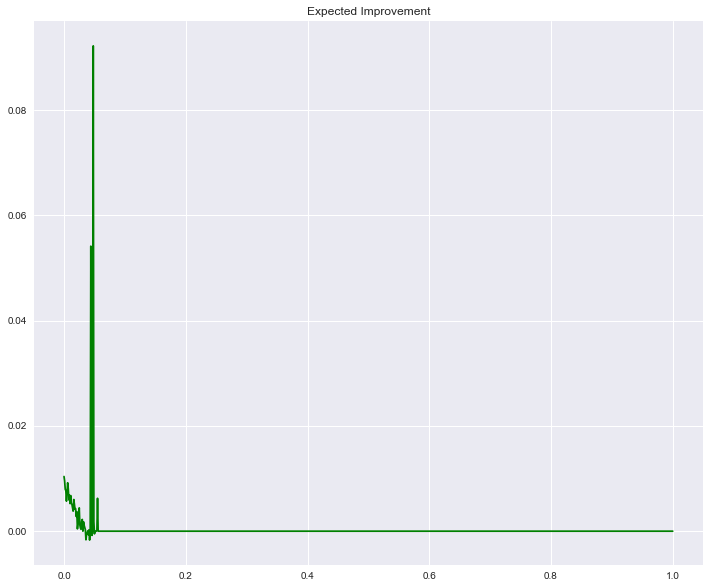

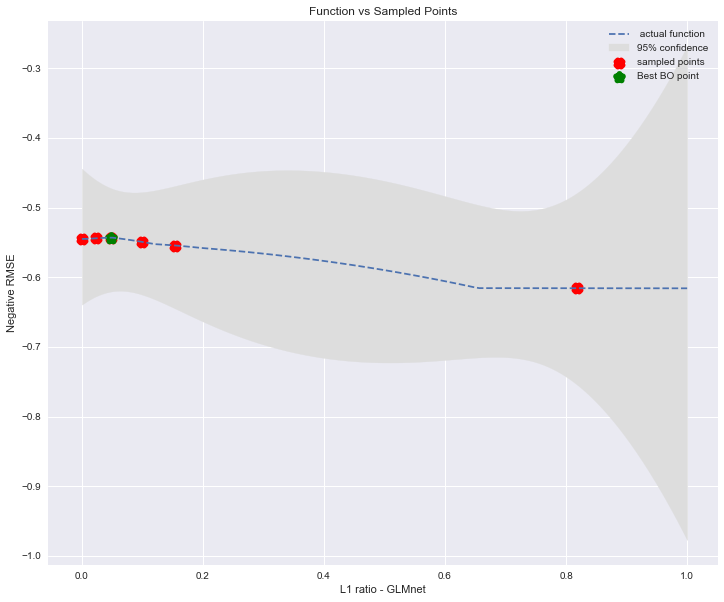

STEP NUMBER = 6
Bayesian Optimization just sampled point = [ 0.01001001]
Best x (Bayesian OPtimization) = [ 0.04804805], Best y = -0.5431180847562334
Point on x-axis just sampled =[ 0.01001001]


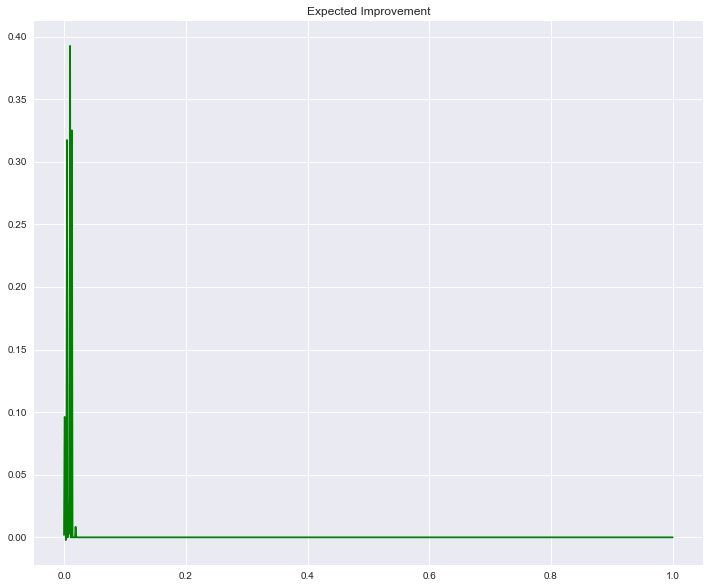

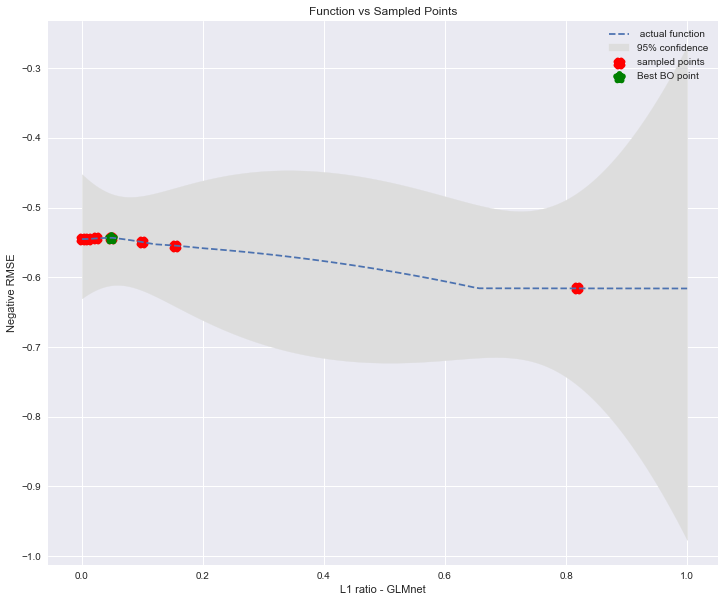

STEP NUMBER = 7
Bayesian Optimization just sampled point = [ 0.03903904]
Best x (Bayesian OPtimization) = [ 0.04804805], Best y = -0.5431180847562334
Point on x-axis just sampled =[ 0.03903904]


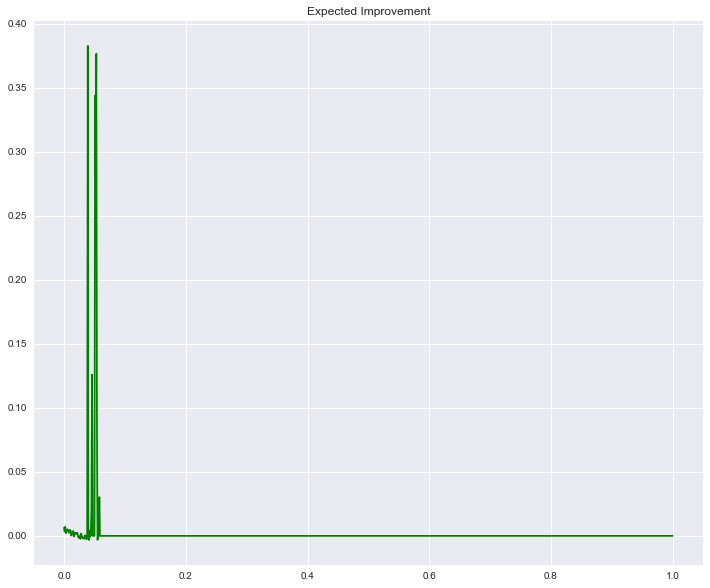

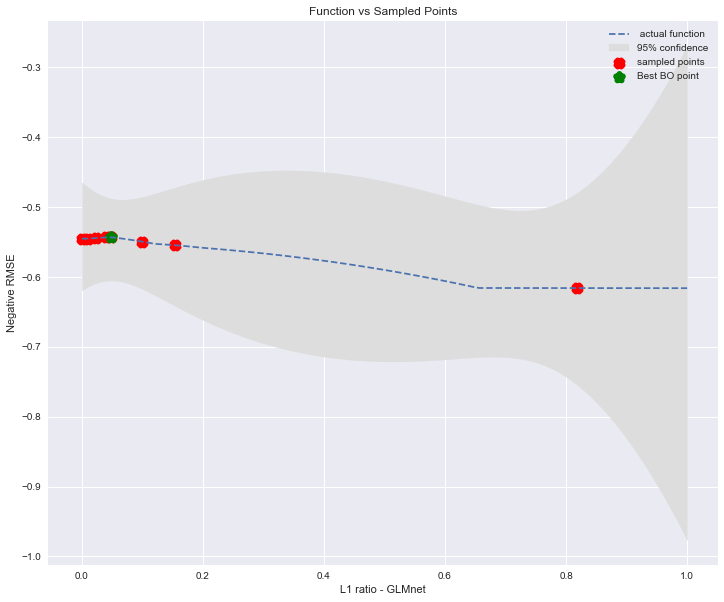

STEP NUMBER = 8
Bayesian Optimization just sampled point = [ 0.002002]
Best x (Bayesian OPtimization) = [ 0.04804805], Best y = -0.5431180847562334
Point on x-axis just sampled =[ 0.002002]


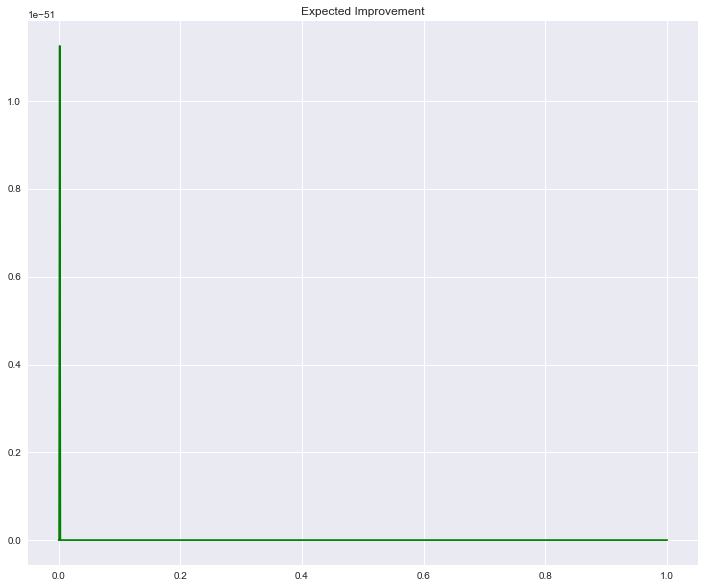

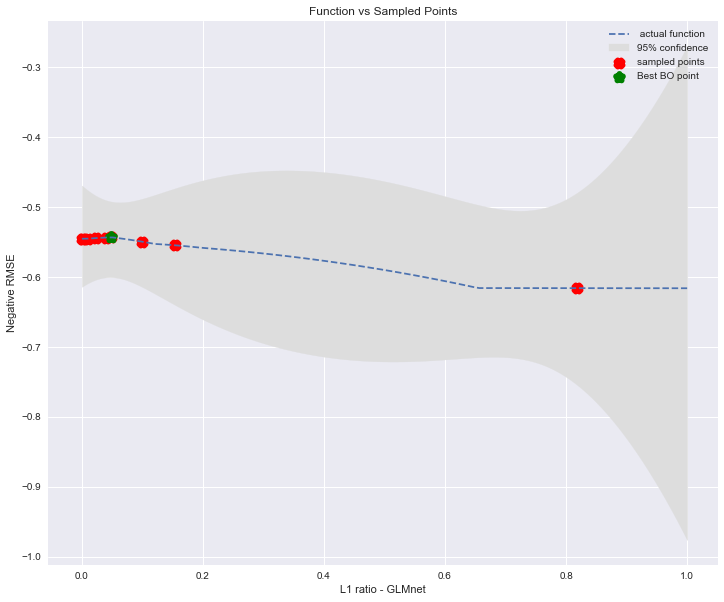

STEP NUMBER = 9
Bayesian Optimization just sampled point = [ 0.07907908]
Best x (Bayesian OPtimization) = [ 0.04804805], Best y = -0.5431180847562334
Point on x-axis just sampled =[ 0.07907908]


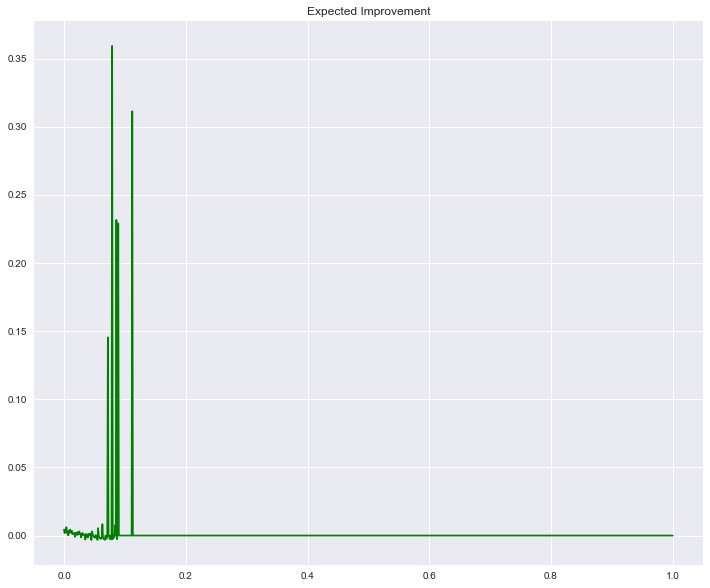

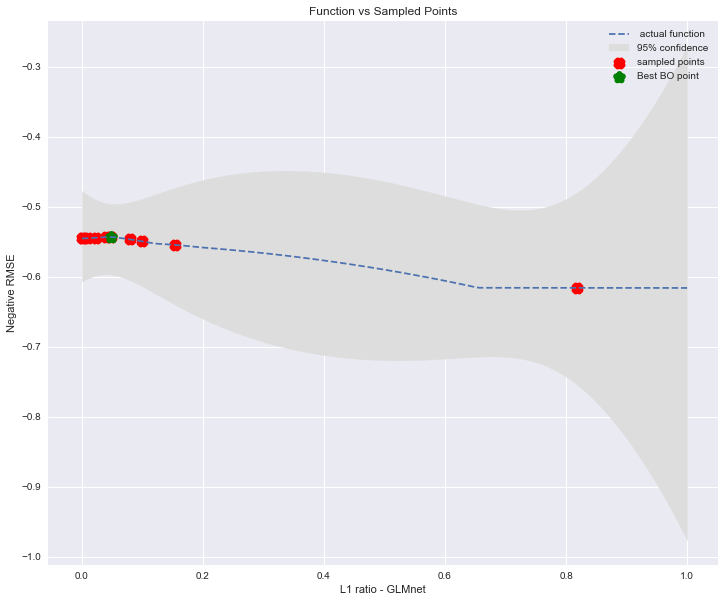

In [1631]:
# Used for Expected Improvement 
# For the real function, plot the values
train_y_x_axis = np.array(np.linspace(0,1,100))
train_y_numbers_ = [hyperparam_choice_function(i) for i  in train_y_x_axis]
    
for i in range(samples):
    print('STEP NUMBER =',i)
     # sample from generator
    x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen_hyp)
    
    
    # Expectd Improvement
    plt.figure(figsize=(12,10))
    plt.title('Expected Improvement')
    plt.plot(domain,improvements,label='Expected improvements',color='green')
    
    
   
     # 95% confidence bars
    plt.figure(figsize=(12,10))
    plt.title("Function vs Sampled Points")
    plt.gca().fill_between( domain.flat, mus-2*np.sqrt(sampled_var),
                           mus+2*np.sqrt(sampled_var), color="#dddddd",label='95% confidence')
    
    
    
    
    
    plt.plot(train_y_x_axis,train_y_numbers_, label=' actual function',linestyle="--")
    
    #print(f"Point on x-axis just sampled ={x_sampled_points[-1]}")
    plt.scatter(x_sampled_points,y_sampled_points, color='red',marker='X',label='sampled points',linewidths=5)
    plt.scatter(best_x,best_y, marker = "*",label='Best BO point',linewidths=6, color = 'green')
    plt.ylabel('Negative RMSE')
    plt.xlabel('L1 ratio - GLMnet')

    
    mus = np.array(mus)
    domain = np.array(domain)

    plt.legend()
    plt.show();

    
    # pause so we can see the graph
    #time.sleep(3);


# Compare performance of finding the l1 ratio to random search and grid search

In [1590]:
def grid_search(range_, h_choice = hyperparam_choice_function):
    """A generator that methodically searches through the input range and returns the x val, and the negative RMSE
   Range should be np.linspace steps = 1k This is the number of steps in the bayesian optimization algo"""
    if len(range_)!=1_000:
        return "Incorrect domain"
    else:
        for x in range_:
            yield (x,h_choice(x))

In [1591]:
def random_grid_search(range_, h_choice = hyperparam_choice_function):
    """Random grid search 
    Return a generator that methodically searches through the input range and returns the x val and
    the negative RMSE.
    Range should be np.linspace = 1k, This is the number of steps in the bayesian optimization algo"""
    sampled_points = []
    if len(range_)!=1_000:
        return "Incorrect domain"
    else:
        for _ in range(len(range_)):
            choice = np.random.choice(t)
            # don't sample the same point twice
            while choice in sampled_points:
                choice = np.random.choice(range_)
            yield (choice,h_choice(choice))

            

In [1632]:
# random gridsearch gen
rand_grid_gen =  random_grid_search(np.linspace(0,1,1_000))
# gridsearch gen
grid_gen = grid_search(np.linspace(0,1,1_000))
# BAYESIAN OPTIMIZATION generator

samples = 10
gen_hyp = sample_from_function(hyperparam_choice_function, train_x_hyp, train_y_hyp,
                               squarred_kernel, y_var_hyp, testing_domain = range(0,2), n=samples )

x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen_hyp)
    

/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


STEP NUMBER = 1
Bayesian Optimization just sampled point = [ 0.75975976]
Best x (Bayesian OPtimization) = [0], Best y = -0.5451045527465782

Grid search just sampled point = 0.0
Best X (Grid Search) = 0.0, Best y = -0.5451045527465782

Random Grid search just sampled point = 0.4874874874874875
Best X (Random Grid Search) = 0.0, Best y = -0.5881028051073086


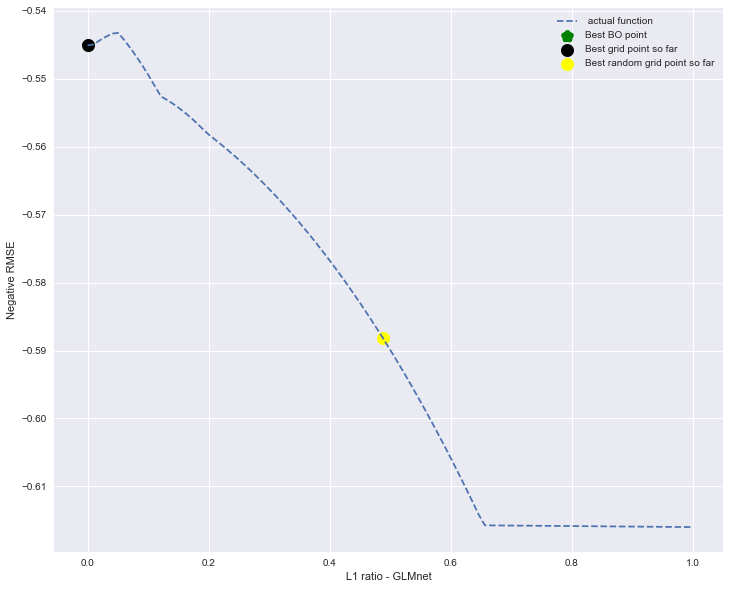

STEP NUMBER = 2
Bayesian Optimization just sampled point = [ 0.05405405]
Best x (Bayesian OPtimization) = [ 0.05405405], Best y = -0.5436286734105492

Grid search just sampled point = 0.001001001001001001
Best X (Grid Search) = 0.001001001001001001, Best y = -0.5450642441599128

Random Grid search just sampled point = 0.3033033033033033
Best X (Random Grid Search) = 0.001001001001001001, Best y = -0.5665456497726399


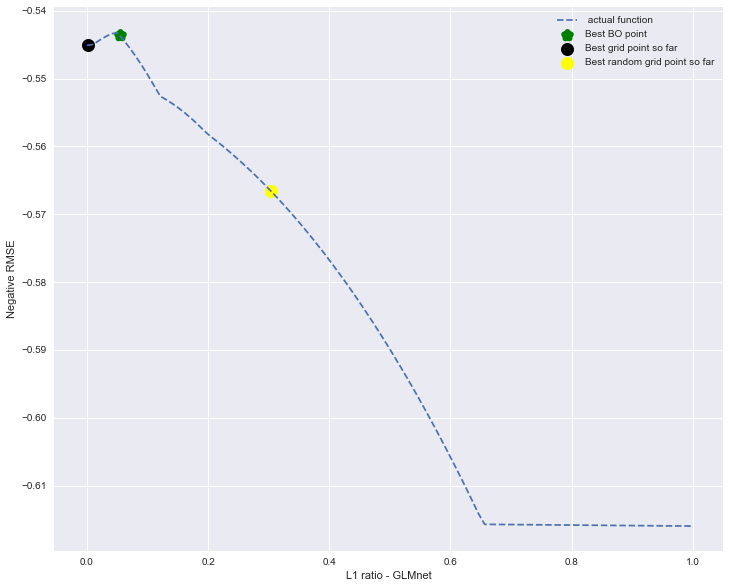

STEP NUMBER = 3
Bayesian Optimization just sampled point = [ 0.1041041]
Best x (Bayesian OPtimization) = [ 0.05405405], Best y = -0.5436286734105492

Grid search just sampled point = 0.002002002002002002
Best X (Grid Search) = 0.002002002002002002, Best y = -0.5450374994316208

Random Grid search just sampled point = 0.25925925925925924
Best X (Random Grid Search) = 0.002002002002002002, Best y = -0.5626839951184633


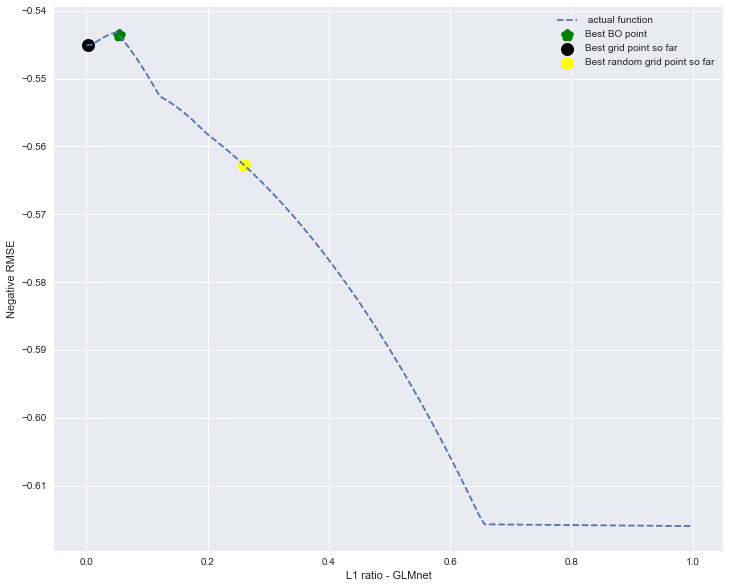

STEP NUMBER = 4
Bayesian Optimization just sampled point = [ 0.98798799]
Best x (Bayesian OPtimization) = [ 0.05405405], Best y = -0.5436286734105492

Grid search just sampled point = 0.003003003003003003
Best X (Grid Search) = 0.003003003003003003, Best y = -0.5450130081867531

Random Grid search just sampled point = 0.25725725725725723
Best X (Random Grid Search) = 0.003003003003003003, Best y = -0.562519824012495


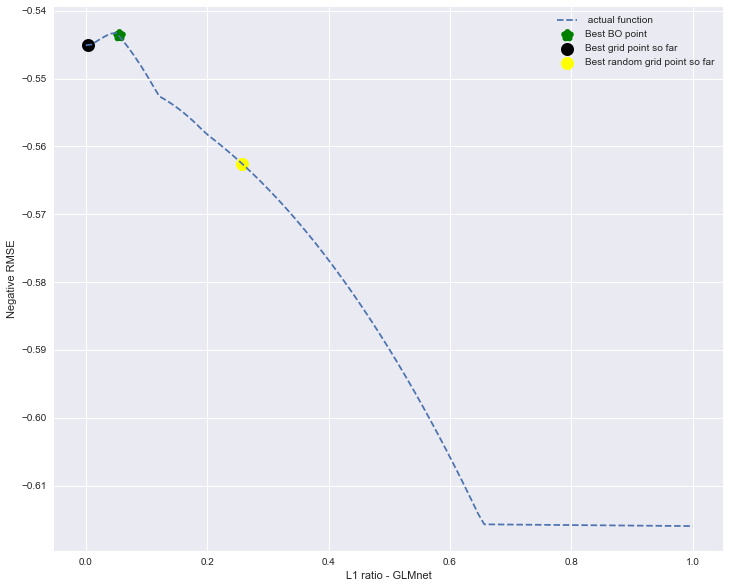

STEP NUMBER = 5
Bayesian Optimization just sampled point = [ 0.03903904]
Best x (Bayesian OPtimization) = [ 0.03903904], Best y = -0.5434311950379803

Grid search just sampled point = 0.004004004004004004
Best X (Grid Search) = 0.003003003003003003, Best y = -0.5450130081867531

Random Grid search just sampled point = 0.20520520520520522
Best X (Random Grid Search) = 0.003003003003003003, Best y = -0.5585910869930893


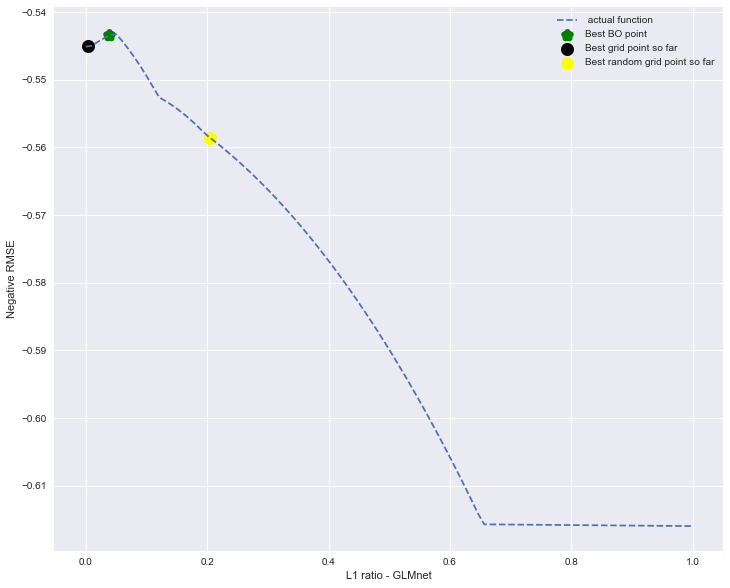

STEP NUMBER = 6
Bayesian Optimization just sampled point = [ 0.08308308]
Best x (Bayesian OPtimization) = [ 0.03903904], Best y = -0.5434311950379803

Grid search just sampled point = 0.005005005005005005
Best X (Grid Search) = 0.003003003003003003, Best y = -0.5450130081867531

Random Grid search just sampled point = 0.983983983983984
Best X (Random Grid Search) = 0.003003003003003003, Best y = -0.5585910869930893


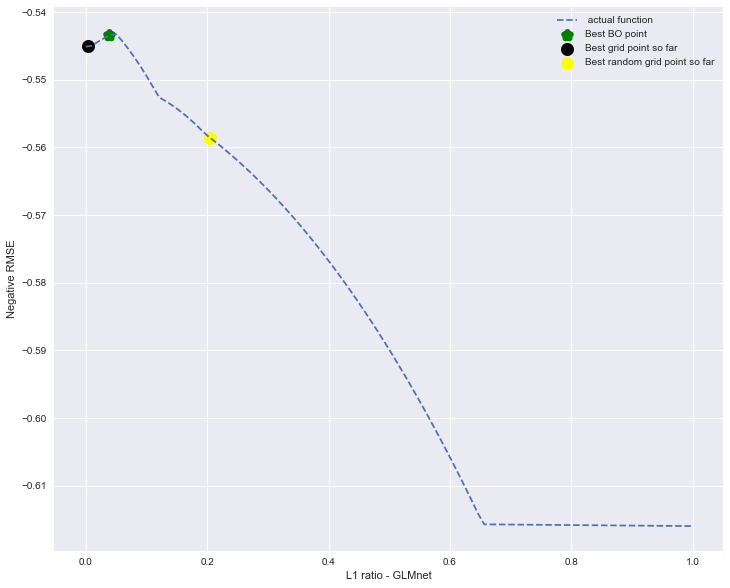

STEP NUMBER = 7
Bayesian Optimization just sampled point = [ 0.02402402]
Best x (Bayesian OPtimization) = [ 0.03903904], Best y = -0.5434311950379803

Grid search just sampled point = 0.006006006006006006
Best X (Grid Search) = 0.003003003003003003, Best y = -0.5450130081867531

Random Grid search just sampled point = 0.7727727727727728
Best X (Random Grid Search) = 0.003003003003003003, Best y = -0.5585910869930893


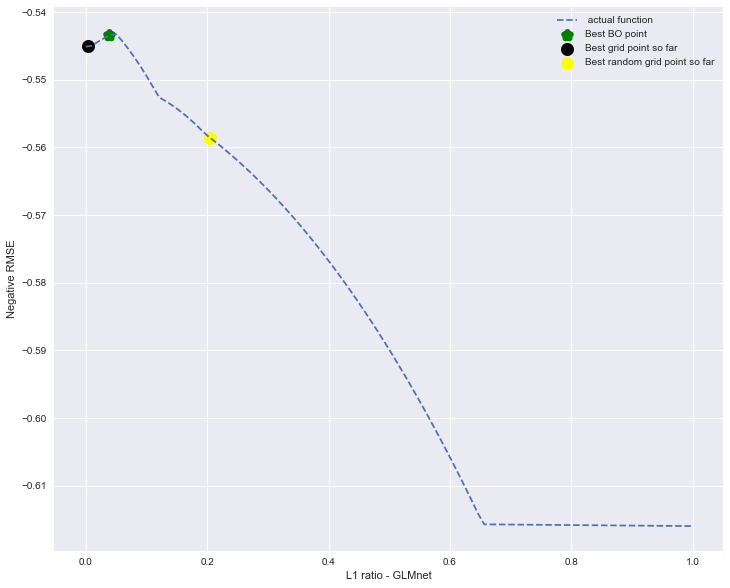

STEP NUMBER = 8
Bayesian Optimization just sampled point = [ 0.02902903]
Best x (Bayesian OPtimization) = [ 0.03903904], Best y = -0.5434311950379803

Grid search just sampled point = 0.007007007007007007
Best X (Grid Search) = 0.003003003003003003, Best y = -0.5450130081867531

Random Grid search just sampled point = 0.9629629629629629
Best X (Random Grid Search) = 0.003003003003003003, Best y = -0.5585910869930893


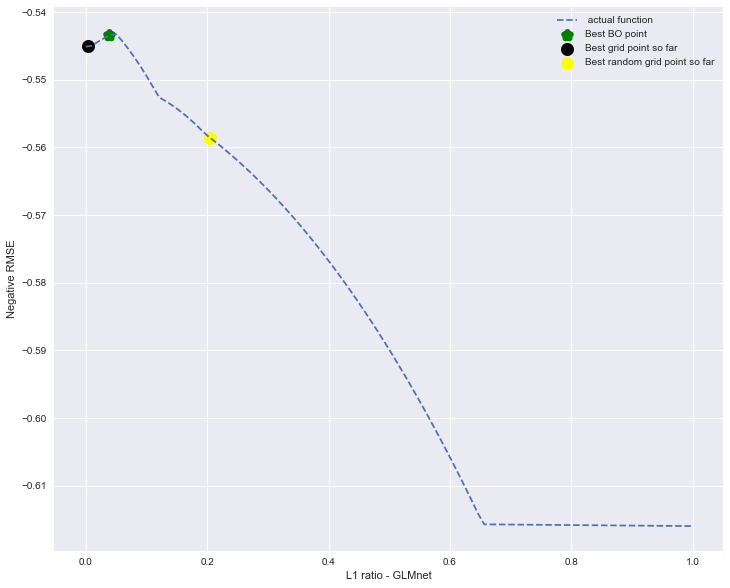

STEP NUMBER = 9
Bayesian Optimization just sampled point = [ 0.]
Best x (Bayesian OPtimization) = [ 0.03903904], Best y = -0.5434311950379803

Grid search just sampled point = 0.008008008008008008
Best X (Grid Search) = 0.003003003003003003, Best y = -0.5450130081867531

Random Grid search just sampled point = 0.01001001001001001
Best X (Random Grid Search) = 0.003003003003003003, Best y = -0.5449657301209059


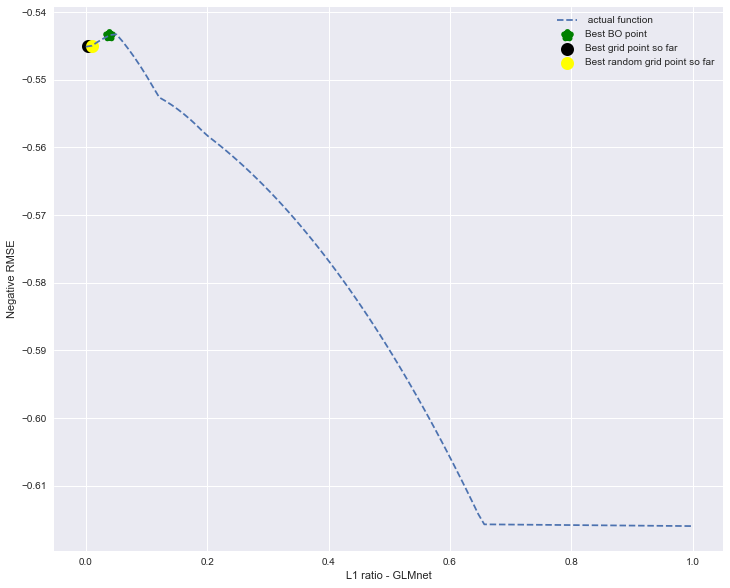

STEP NUMBER = 10


StopIteration: 

In [1633]:
# Plot Bayesian Optimization vs grid search
# For the real function, plot the values
train_y_x_axis = np.array(np.linspace(0,1,100))
train_y_numbers_ = [hyperparam_choice_function(i) for i  in train_y_x_axis]
# keep track of best points for grid search
best_y_grid = -9999999
best_x_grid = None
sampled_x_grid = []
sampled_y_grid = []
# keep track of best points for random grid search
best_y_grid_rand = -9999999
best_x_grid_rand = None
sampled_x_grid_rand = []
sampled_y_grid_rand = []

for i in range(samples):

    print('STEP NUMBER =',i+1)
    # sample from generator
    x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen_hyp)
    # sample from gridsearch
    x_grid, y_grid = next(grid_gen)
    #sample from random gridsearch
    x_grid_rand, y_grid_rand = next(rand_grid_gen) 
    
    # keep track of best gridsearch parameters
    if y_grid > best_y_grid:
        best_y_grid = y_grid
        best_x_grid = x_grid
    if y_grid_rand > best_y_grid_rand:
        best_y_grid_rand = y_grid_rand
        best_x_grid_rand = x_grid_rand
    # append these points to the list we are keeping track of for grid search 
    sampled_x_grid.append(x_grid)
    sampled_y_grid.append(y_grid)
    sampled_x_grid_rand.append(x_grid_rand)
    sampled_y_grid_rand.append(y_grid_rand)
    print()
    print(f"Grid search just sampled point = {x_grid}")
    print(f"Best X (Grid Search) = {best_x_grid}, Best y = {best_y_grid}")
    print()
    print(f"Random Grid search just sampled point = {x_grid_rand}")
    print(f"Best X (Random Grid Search) = {best_x_grid}, Best y = {best_y_grid_rand}")
    
    #plot actual function
    plt.figure(figsize=(12,10))
    plt.plot(train_y_x_axis,train_y_numbers_, label=' actual function',linestyle="--")
    plt.ylabel('Negative RMSE')
    plt.xlabel('L1 ratio - GLMnet')
    
    # Results so far from bayesian optimization
    #plt.scatter(x_sampled_points,y_sampled_points, color='red',marker='X',label='sampled points - BO',linewidths=5)
    plt.scatter(best_x,best_y, marker = "*",label='Best BO point',linewidths=6, color = 'green') # best point
    
    # Results from grid search
    #plt.scatter(sampled_x_grid,sampled_y_grid, marker = 'o', label='Grid Search points', color='orange',linewidths=6)
    plt.scatter(best_x_grid,best_y_grid , label='Best grid point so far', linewidths=6, color = 'Black')
    
    # Results from random grid search
    #plt.scatter(sampled_x_grid_rand, sampled_y_grid_rand, marker = 'o', label='Random Grid Search points', color='maroon',linewidths=6)
    plt.scatter(best_x_grid_rand, best_y_grid_rand , label='Best random grid point so far', linewidths=6, color = 'Yellow')
    
    plt.legend()
    plt.show();

# Run this optimization 50 times with step size 10 and see how many times each optimization method wins
- Each optimization is looking at domain (0,1) with 1k samples between 0 and 1
- step size is the number of 'steps' that each optimization algorithm will take
- Use squarred kernel for Bayesian Optimization


In [1636]:
grid_wins = 0 # number of time sthat grid search won
random_grid_wins = 0 # number of time that random grid search won
bo_wins = 0 # number of times bayesian optimization won
n_trials = 20
samples = 10
for trial in range(n_trials):
    print('TRIAL NUMBER = ',trial)
    # initialize new generators for each trial
    # random gridsearch gen
    rand_grid_gen =  random_grid_search(np.linspace(0,1,1_000))
    # gridsearch gen
    grid_gen = grid_search(np.linspace(0,1,1_000))
    # BAYESIAN OPTIMIZATION generator
    gen_hyp = sample_from_function(hyperparam_choice_function, train_x_hyp, train_y_hyp,
                                   squarred_kernel, y_var_hyp, testing_domain = range(0,2), n=samples, verbose=False )


    # keep track of best points for grid search
    best_y_grid = -9999999
    best_x_grid = None
    sampled_x_grid = []
    sampled_y_grid = []
    # keep track of best points for random grid search
    best_y_grid_rand = -9999999
    best_x_grid_rand = None
    sampled_x_grid_rand = []
    sampled_y_grid_rand = []

    for iteration in range(samples): # iteration is the number of steps for each optimizer to take 
        #sample from generator
        x_sampled_points, y_sampled_points, sampled_var, best_x, best_y, improvements, domain, mus = next(gen_hyp)
        # sample from gridsearch
        x_grid, y_grid = next(grid_gen)
        #sample from random gridsearch
        x_grid_rand, y_grid_rand = next(rand_grid_gen) 
        # keep track of best gridsearch parameters
        if y_grid > best_y_grid:
            best_y_grid = y_grid
            best_x_grid = x_grid
        if y_grid_rand > best_y_grid_rand:
            best_y_grid_rand = y_grid_rand
            best_x_grid_rand = x_grid_rand
            
    if (best_y_grid_rand > best_y_grid) & (best_y_grid_rand > best_y):
        print('Random Grid Search had the best parameter')
        random_grid_wins+=1
    elif (best_y_grid > best_y) & (best_y_grid>best_y_grid_rand):
        print("Grid Search had the best parameter")
        grid_wins+=1
    else:# BO was the best
        print('Bayesian optimization had the  best parameter')
        bo_wins+=1
        

        
        

TRIAL NUMBER =  0


/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:470: UserWarning: Coordinate descent with alpha=0 may lead to unexpected results and is discouraged.
  positive)
/Users/jonathanhilgart/anaconda/envs/stats/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Bayesian optimization had the  best parameter
TRIAL NUMBER =  1
Bayesian optimization had the  best parameter
TRIAL NUMBER =  2
Bayesian optimization had the  best parameter
TRIAL NUMBER =  3
Random Grid Search had the best parameter
TRIAL NUMBER =  4
Bayesian optimization had the  best parameter
TRIAL NUMBER =  5
Bayesian optimization had the  best parameter
TRIAL NUMBER =  6
Bayesian optimization had the  best parameter
TRIAL NUMBER =  7
Grid Search had the best parameter
TRIAL NUMBER =  8
Bayesian optimization had the  best parameter
TRIAL NUMBER =  9
Bayesian optimization had the  best parameter
TRIAL NUMBER =  10
Bayesian optimization had the  best parameter
TRIAL NUMBER =  11
Bayesian optimization had the  best parameter
TRIAL NUMBER =  12
Bayesian optimization had the  best parameter
TRIAL NUMBER =  13
Bayesian optimization had the  best parameter
TRIAL NUMBER =  14
Random Grid Search had the best parameter
TRIAL NUMBER =  15
Random Grid Search had the best parameter
TRIAL NUMBE

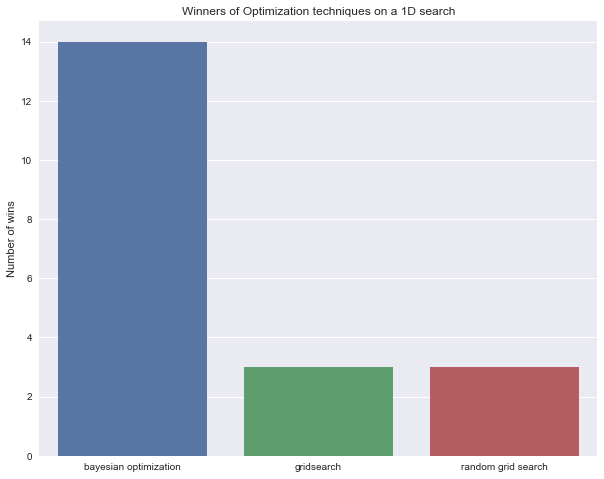

In [1637]:
plt.figure(figsize=(10,8))
sns.barplot(x=['bayesian optimization','gridsearch','random grid search'],y=[bo_wins ,grid_wins , random_grid_wins  ])
plt.ylabel('Number of wins')
plt.title('Winners of Optimization techniques on a 1D search')

- Random grid search works pretty well in one dimesion. However, as the dimensionality increases, then Bayesian optimization should continue to perform better.